# Tutorial 4: Analysis

In this tutorial we will show some analysis that have been useful for us in the last months.
I hope it may be th same for you!

We'll briefly have a look at how `mlcolvar` can also be used to perform sensitivity analysis / feature relevance on model we train and at clustering approaches showing how both techniques can be used to make our life easier in interpreting the simulations results.

## Import modules

In [1]:
# general import
import torch
import numpy as np
import matplotlib.pyplot as plt

# embed pngs into python plots
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import matplotlib.image as image

# mlcolvar modules
from mlcolvar.utils.plot import paletteFessa
from mlcolvar.data import DictDataset
from mlcolvar.utils.io import create_dataset_from_files

## Trivial sensitivity analysis on Muller
This is mostly a game to show the machinery :)

### Load data

In [2]:
filenames = ["../1_enhanced_sampling/simulations/unbiased_sims/A/COLVAR",
             "../1_enhanced_sampling/simulations/unbiased_sims/B/COLVAR",]

dataset, dataframe = create_dataset_from_files(file_names=filenames,
                                               create_labels = True,
                                               filter_args={'regex': 'p.x|p.y'},
                                               return_dataframe=True,
                                               stop = 8000,
                                               stride=1)

Class 0 dataframe shape:  (8000, 17)
Class 1 dataframe shape:  (8000, 17)

 - Loaded dataframe (16000, 17): ['time', 'p.x', 'p.y', 'p.z', 'mueller', 'potential.bias', 'potential.mueller_bias', 'lwall_x.bias', 'lwall_x.force2', 'uwall_x.bias', 'uwall_x.force2', 'lwall_y.bias', 'lwall_y.force2', 'uwall_y.bias', 'uwall_y.force2', 'walker', 'labels']
 - Descriptors (16000, 2): ['p.x', 'p.y']


### Sensitivity analysis

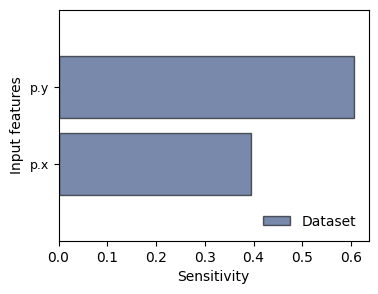

In [3]:
from mlcolvar.explain import sensitivity_analysis

# load our previously trained model
trained_model = torch.jit.load('../3_committor/models/model_0_q.pt')

fig, ax = plt.subplots(1,1,figsize=(4,3))
results = sensitivity_analysis(trained_model,
                               dataset,
                               metric="mean_abs_val",   # metric to use to compute the sensitivity per feature (e.g. mean absolute value or root mean square)
                               feature_names=None,      # by default, they will be taken from `dataset.feature_names`
                               per_class=False,         # whether to do per-class statistics
                               plot_mode='barh',
                               ax = ax)          

## Finally a real example: Chignolin protein

### Load data

In [4]:
filenames = ['https://raw.githubusercontent.com/alphatestK/Committor/main/chignolin/data/COLVAR.8.u',
             'https://raw.githubusercontent.com/alphatestK/Committor/main/chignolin/data/COLVAR.8.f',
             'https://raw.githubusercontent.com/alphatestK/Committor/main/chignolin/data/COLVAR.9.u',
             'https://raw.githubusercontent.com/alphatestK/Committor/main/chignolin/data/COLVAR.9.f']   

dataset, dataframe = create_dataset_from_files(file_names=filenames,
                                               create_labels = True,
                                               filter_args={'regex' : 'x[1-9]|x[1-4][0-9]'},
                                               return_dataframe=True,
                                               stride=1)

Class 0 dataframe shape:  (40001, 140)
Class 1 dataframe shape:  (40001, 140)
Class 2 dataframe shape:  (40001, 140)
Class 3 dataframe shape:  (40001, 140)

 - Loaded dataframe (160004, 140): ['time', 'rmsd_ca', 'end', 'ene', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'p1.a', 'p1.b', 'p1.c', 'p2.a', 'p2.b', 'p2.c', 'p3.a', 'p3.b', 'p3.c', 'p4.a', 'p4.b', 'p4.c', 'p5.a', 'p5.b', 'p5.c', 'p6.a', 'p6.b', 'p6.c', 'p7.a', 'p7.b', 'p7.c', 'p8.a', 'p8.b', 'p8.c', 'p9.a', 'p9.b', 'p9.c', 'p10.a', 'p10.b', 'p10.c', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'cont15', 'cont16', 'cont17', 'cont18', 'cont19', 'cont20', 'cont21', 'cont22', 'cont23', 'con

### Evaluate committor and visualize trajectories

160004


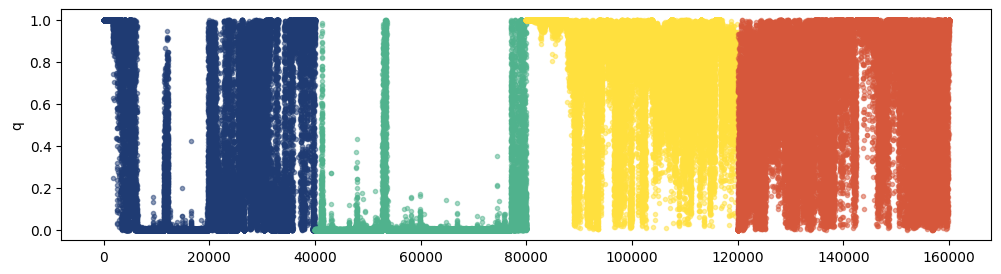

In [7]:
model = torch.jit.load('model_chignolin.pt').to(torch.device('cpu')).to(torch.float32)

# compute the q value over the trajectories
dataframe['model_q'] = model(dataset['data']).detach().numpy()

fig, ax = plt.subplots(1,1,figsize=(12,3))
for i in range(dataframe['labels'].max() + 1):
    aux = dataframe.loc[dataframe.labels==i]
    ax.plot(aux['model_q'], '.', alpha=0.5, color=paletteFessa[i*2])
    ax.set_ylabel('q')
print(len(dataframe))

### Create a TSE dataset

13082


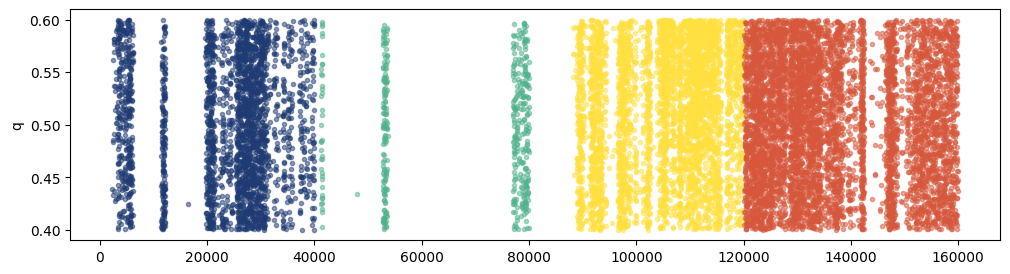

In [8]:
# we can roughly get the TSE configurations according to the committor value
mask = np.logical_and(dataframe['model_q'] > 0.4, dataframe['model_q'] < 0.6)
sub_dataframe = dataframe.loc[mask]
sub_dataset = DictDataset({'data' : torch.Tensor(sub_dataframe.filter(regex='x[1-9]|x[1-4][0-9]').values),
                           'labels' : torch.Tensor(sub_dataframe['labels'].values) })

# visualize the new dataset
fig, ax = plt.subplots(1,1,figsize=(12,3))
for i in range(sub_dataframe['labels'].max() + 1):
    aux = sub_dataframe.loc[sub_dataframe.labels==i]
    ax.plot(aux['model_q'], '.', alpha=0.5, color=paletteFessa[i*2])
    ax.set_ylabel('q')
print(len(sub_dataframe))

### Sensitivity analysis

Plotting only the first 15 features out of 45.


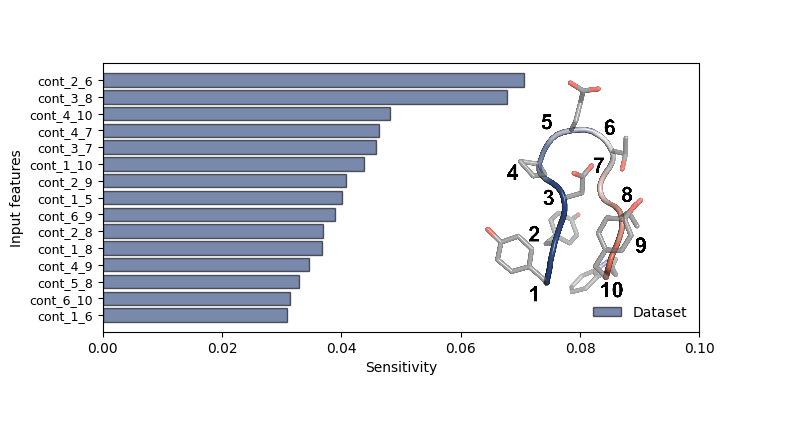

In [9]:
from mlcolvar.explain import plot_sensitivity

# create feature names for safety :)
feature_names = []
for i in range(10):
    for j in range(i+1, 10):
        feature_names.append(f"cont_{i+1}_{j+1}")

# perform sensistiviy analysis
results = sensitivity_analysis(model,
                               sub_dataset,
                               metric="mean_abs_val",            # metric to use to compute the sensitivity per feature (e.g. mean absolute value or root mean square)
                               feature_names=feature_names,      # by default, they will be taken from `dataset.feature_names`
                               per_class=False,                  # whether to do per-class statistics
                               plot_mode=None)      

# plot results
fig, ax = plt.subplots(1,1,figsize=(8,4))
plot_sensitivity(results, mode='barh', max_features=15, ax=ax)
ax.set_xlim(0, 0.1)

# add chignolin sketch for reference
B = image.imread('../figures/chignolin_labeled_atoms.png')
B_box = OffsetImage(B, zoom = 0.14)
B_ab = AnnotationBbox(B_box, (0.08, 6), frameon = False)
ax.add_artist(B_ab)

plt.tight_layout()
plt.show()

We can have a look at our data in the C-2_6 and C-3_8 space

Text(0, 0.5, 'd3-8')

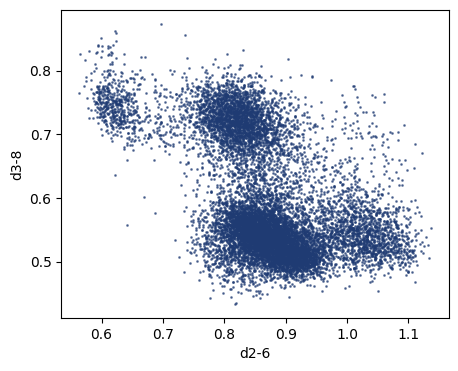

In [10]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.scatter(sub_dataframe['x13'], sub_dataframe['x22'], s=1, alpha=0.6, color=paletteFessa[0])
ax.set_xlabel('d2-6')
ax.set_ylabel('d3-8')

### Clustering analysis

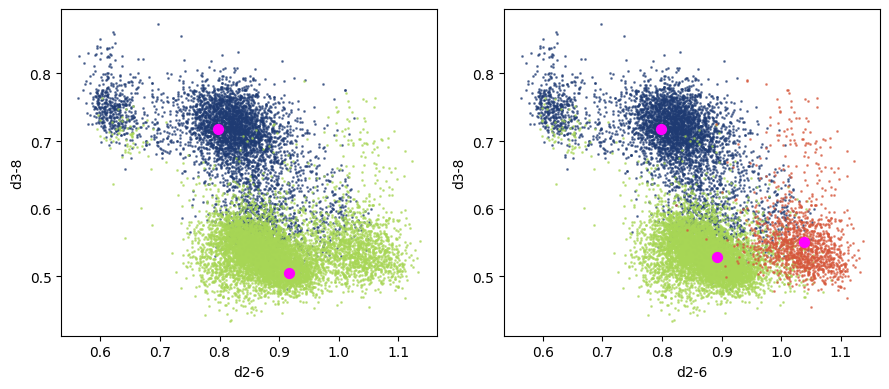

In [11]:
from sklearn_extra.cluster import KMedoids

# we use the distances as variables for the clustering
data = sub_dataframe.filter(regex='x[1-9]|x[1-4][0-9]')

# it would be wise to experiment with different number of clusters, we'll try 2 and 3

fig, axs = plt.subplots(1,2,figsize=(9,4))
for j, n_cluster  in enumerate([2,3]):
    # this does the whole trick actually
    kmedoids = KMedoids(n_clusters=n_cluster, metric='euclidean',method='pam',max_iter=4000).fit(data)

    # we can store the results in nice way
    cluster_masks = []
    medoids = []
    cluster_labels = np.array(kmedoids.labels_)
    for i in range(n_cluster):
        cluster_masks.append(cluster_labels==i)
        medoids.append(data.values[kmedoids.medoid_indices_[i]])


    # we plot everything
    ax = axs[j]
    for i in range(n_cluster):
        ax.scatter(data.loc[cluster_masks[i]]['x13'], data.loc[cluster_masks[i]]['x22'], s=1, alpha=0.6, color=paletteFessa[i*3])
        ax.scatter(medoids[i][12], medoids[i][21], s=200, marker='.', color='magenta')
    ax.set_xlabel('d2-6')
    ax.set_ylabel('d3-8')

plt.tight_layout()
plt.show()

## Visualizing the clusters

<center><img src="figures/medoid_1.png" width="400" /><img src="figures/medoid_2.png" width="400" /><img src="figures/medoid_3.png" width="400" /></center>
